In [1]:
import os
import sys
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

In [43]:
# file_path = "datasets/Restaurant_reviews/Restaurants_Train_v2.csv"
# file_path = "datasets/laptops_reviews/laptops-trial.csv"
file_path = "datasets/laptops_reviews/Laptop_Train_v2.csv"
raw_data = pd.read_csv(file_path)
print(raw_data.head())
reviews = raw_data[["id", "Sentence", "Aspect Term"]]
reviews.head()

     id                                           Sentence     Aspect Term  \
0  2339  I charge it at night and skip taking the cord ...            cord   
1  2339  I charge it at night and skip taking the cord ...    battery life   
2  1316  The tech guy then said the service center does...  service center   
3  1316  The tech guy then said the service center does...    "sales" team   
4  1316  The tech guy then said the service center does...        tech guy   

   polarity  from   to  
0   neutral    41   45  
1  positive    74   86  
2  negative    27   41  
3  negative   109  121  
4   neutral     4   12  


,id,Sentence,Aspect Term
0,2339,I charge it at night and skip taking the cord ...,cord
1,2339,I charge it at night and skip taking the cord ...,battery life
2,1316,The tech guy then said the service center does...,service center
3,1316,The tech guy then said the service center does...,"""sales"" team"
4,1316,The tech guy then said the service center does...,tech guy


In [44]:
reviews.rename(columns={"id": "id", "Sentence": "text", "Aspect Term": "original_aspects"}, inplace=True)
reviews.columns

/var/folders/mj/qz0vbkcs717cq8rm4j5x5q200000gn/T/ipykernel_80151/4023342088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.rename(columns={"id": "id", "Sentence": "text", "Aspect Term": "original_aspects"}, inplace=True)


Index(['id', 'text', 'original_aspects'], dtype='object')

In [45]:
# list all the aspects of a sentence in one column
results = {}
for row in reviews.itertuples():
    if row.text in results:
        results[row.text].append(row.original_aspects)
        
        
    else:
        results[row.text] = [row.original_aspects]

In [46]:
# proper formatting
all_reviews = []
for key, val in results.items():
    all_reviews.append({"review": key, "actual_aspects": list(set(val))}) # getting unique actual aspects

In [47]:
all_reviews[0]

{'review': 'I charge it at night and skip taking the cord with me because of the good battery life.',
 'actual_aspects': ['battery life', 'cord']}

In [48]:
# !python3 -m spacy download en_core_web_lg

In [49]:
nlp = spacy.load("en_core_web_lg")
# nlp = spacy.load("en_core_web_sm")

In [50]:
def apply_extraction(review_body, nlp):
    # review_body = row["Sentence"]
    # review_id = row["id"]
    
    doc = nlp(review_body)
            
    # rule1 - Ex: The phone is very lightweight to carry.
    r1_pairs = []
    for token in doc:
        A = ""
        M = ""
        for child in token.children:
            if child.dep_ == "nsubj" and child.pos_ == "NOUN":
                A = child.text
                
            if not M and child.dep_ == "dobj" and child.pos_ != "NOUN":
                M = child.text

            if not M and child.dep_ == "acomp":
                M = child.text
        if A and M:
            r1_pairs.append((A, M))
            
    # rule1
    r2_pairs = []
    for token in doc:
        if token.dep_ in ("amod", "advmod") and token.head.pos_ == "NOUN":
            A = token.head.text
            # check if it is a noun phrase or not
            for c in token.head.children:
                if c.pos_ == "NOUN" and c.dep_ == "compound":
                    A = c.text + " " + A
                    M = token.text
            if A and not M:
                M = token.text
        if A and M:
            r2_pairs.append((A, M))
            
    # rule3
    r3_pairs = []
    # prev_token_pos = ""
    for token in doc:
        A = ""
        M = ""
        for child in token.children:
            if token.pos_ == "NOUN" and child.dep_ == "prep":
                A = token.text
                M = child.text
            # if prev_token_pos != "NOUN" and token.dep_ =="prep" and token.pos_ == "ADP" and child.dep_ == "pobj":
            #     A = child.text
        if A and not M:
            r3_pairs.append((A, M))
        # prev_token_pos = token.pos_

            
    # rule4
    r4_pairs = []
    for token in doc:
        children = token.children
        A = ""
        M = ""
        for child in children:
            if child.dep_ == "nsubjpass":
                A = child.text
                
            if child.dep_ == "advmod":
                M = child.text
        
        if A and M:
            r4_pairs.append((A, M))
            
    # rule5
    r5_pairs = []
    for token in doc:
        children = token.children
        A = ""
        M = ""
        for child in children:
            if child.dep_ == "nsubj":
                A = child.text
                
            if child.dep_ == "cop":
                M = child.text
        
        if A and M:
            r5_pairs.append((A, token.text))
            
    # rule 6 - Ex. I like the lens of the screen.
    r6_pairs = []
    for token in doc:
        A = ""
        M = ""
        if token.pos_ == "VERB":
            for child in token.children:
                if child.dep_ == "nsubj" and child.pos_ == "PRON":
                    continue
                if child.dep_ == "dobj" and child.pos_ == "NOUN":
                    phrase1 = child.text
                    # check if it is a noun phrase or not
                    for c in child.children:
                        if c.pos_ == "NOUN" and c.dep_ == "compound":
                            A = c.text + " " + phrase1
                            M = token.text
        if A and M:
            r6_pairs.append((A, M))
                
                
    # rule 7 - I would like to comment on the camera of this phone.
    A = ""
    M= ""
    r7_pairs=[]
    for i in range(len(doc)-1):
        if doc[i].pos_ == "VERB" and doc[i+1].pos_ == "ADP" and doc[i+1].dep_ == "prep":
            for token in doc[i+1:]:
                for child in token.children:
                    if child.dep_ == "pobj" and child.pos_ == "NOUN":
                        A = child.text
                        M = doc[i].text
                break   
        if A and M:
            r7_pairs.append((A, M))
            break
            
    # rule 8 - It is easy to use
    r8_pairs = []
    for token in doc:
        A = ""
        M = ""
        if token.pos_ == "AUX" and len([child for child in token.children]) >= 2:
            for child in token.children:
                if child.dep_ == "acomp" and child.pos_ == "ADJ":
                    M = child.text
                if child.dep_ == "xcomp" and child.pos_ in ("VERB", "NOUN"):
                    A = child.text
            if A and M:
                r8_pairs.append((A, M))

            
    #rule 9 - If no noun in the sentence, use propnoun as aspect
    # ex- Keyboard good sized and wasy to use.
    r9_pairs = []
    if "NOUN" not in [token.pos_ for token in doc]:
        for token in doc:
            if token.pos_ == "PROPN":
                A = token.text
                M = ""
                r9_pairs.append((A, M))
    
    # aspects = []
    # print(r1_pairs, r2_pairs, r3_pairs, r4_pairs, r5_pairs, r6_pairs, r7_pairs, r8_pairs, r9_pairs)
    aspects_pairs = r1_pairs + r2_pairs + r3_pairs + r4_pairs + r5_pairs + r6_pairs + r7_pairs + r8_pairs + r9_pairs
    # aspect_dict = {"review_id": review_id, "review_body": review_body, "aspect_pairs": aspects}
    return list(set(aspects_pairs))

In [51]:
# text = "The price and features more than met my needs."
text = "It was truly a great computer costing less than one thousand bucks before tax."
doc = nlp(text)
apply_extraction(doc, nlp)
# extract_noun_chunk(text, nlp)

[('computer', 'great')]

In [11]:
# all_reviews[0], len(all_reviews)

In [12]:
nchunks = []
for np in nlp("The fried rice is amazing here.").noun_chunks:
    nchunks.append(" ".join([token.text for token in np if not token.is_stop]))
nchunks

['fried rice']

In [52]:
def extract_aspects(pairs):
    """
    extract aspects from (aspects, opinion words) tuple
    """
    aspects = list(set([i[0] for i in pairs]))
    filtered_aspects = []
    for w in aspects:
        # remove pronouns from aspects
        if nlp(w)[0].pos_ != "PRON":
            filtered_aspects.append(w)
    return filtered_aspects

def extract_noun_chunk(review, nlp):
    """
    get noun chunk for review
    """
    nchunks = []
    for np in nlp(review).noun_chunks:
        nchunks.append(" ".join([token.text for token in np if not token.is_stop]))
    return nchunks

def find_noun_phrase(aspects, noun_chunks):
    """
    find corresponding noun phrase for extracted aspect (noun)
    """
    # get noun phrase for the aspects 
    # new_aspects = []
    # for ap in aspects:
    #     new = ""
    #     for nc in noun_chunks:
    #         if ap not in nc.split(" "):
    #             continue
    #         else:
    #             new = nc
    #             break
    #     if new:
    #         new_aspects.append(new)
    #     else:
    #         new_aspects.append(ap)
        
                
    # for small sentences, usually the noun phrases are aspects
    if not aspects and len(noun_chunks) <= 2:
        return [i for i in noun_chunks if i]
    # return new_aspects
    return aspects

In [14]:
# text = "The tables are crammed way too close, the menu is typical of any Italian restaurant, and the wine list is simply overpriced."
text = "We ordered the chicken casserole, but what we got were a few small pieces of chicken, all dark meat and on the bone"
a = extract_aspects(apply_extraction(text, nlp))
nc = extract_noun_chunk(text, nlp)

a
apply_extraction(text, nlp)
# , nc, find_noun_phrase(a, nc)

[] [('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('meat', 'few'), ('meat', 'few'), ('meat', 'few'), ('meat', 'few'), ('meat', 'few'), ('meat', 'few')] [] [] [] [('chicken casserole', 'ordered')] [] [] []
[] [('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('pieces', 'few'), ('meat', 'few'), ('meat', 'few'), ('meat', 'few'), ('meat', 'few'), ('meat', 'few'), ('meat', 'few')] [] [] [] [('chicken casserole', 'ordered')] [] [] []


[('pieces', 'few'), ('chicken casserole', 'ordered'), ('meat', 'few')]

In [53]:
import math
from collections import Counter

def find_similarity(l1, l2):
    c1 = Counter(l1)
    c2 = Counter(l2)
    
    # cosine similarity
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [54]:
for data in tqdm(all_reviews):
    extracted_aspects = extract_aspects(apply_extraction(data["review"], nlp))
    noun_chunks = extract_noun_chunk(data["review"], nlp)
    data["extracted_aspects"] = find_noun_phrase(extracted_aspects, noun_chunks)
    try:
        data["similarity"] = find_similarity(data["actual_aspects"], data["extracted_aspects"])
    except ZeroDivisionError:
        data["similarity"] = 0
    if data["similarity"] >=0.8:
        data["check"] = True
    else:
        data["check"] = False

100%|█████████████████████████████████████████| 1482/1482 [00:36<00:00, 41.01it/s]


In [55]:
all_reviews[0]

{'review': 'I charge it at night and skip taking the cord with me because of the good battery life.',
 'actual_aspects': ['battery life', 'cord'],
 'extracted_aspects': ['battery life'],
 'similarity': 0.7071067811865475,
 'check': False}

In [78]:
def compute_precision(reviews):
    TP = 0
    FP = 0 
    FN = 0
    TN = 0
    for data in reviews:
        # extracted
        for word in data["extracted_aspects"]:            # and are actual aspects
            if word in data["actual_aspects"]:
                TP += 1
            # not actual aspects
            if word not in data["actual_aspects"]:
                FP += 1
        # not extracted - but are aspects
        for word in data["actual_aspects"]:
            if word not in data["extracted_aspects"]:
                FN += 1
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

In [79]:
precision, recall, f1 = compute_precision(all_reviews)
precision, recall, f1

(0.33796296296296297, 0.28577642453240537, 0.30968654254065525)

In [58]:
pd.DataFrame(all_reviews).to_csv("output/extracted_laptop_aspects_v3.csv")

In [80]:
aspects=[i for a in all_reviews for i in a["extracted_aspects"]]
len(aspects)

1944

#### Clustering the extracted aspects

In [81]:
import gensim
from sklearn.manifold import TSNE


def find_optimal_num_cluster(aspect_vectors):
    num_clusters = range(2,7)
    kmeans = [KMeans(n_clusters=i, max_iter=200) for i in num_clusters]
    # try elbow method to get num clusters
    # score = [kmeans[i].fit(aspect_vectors).score(aspect_vectors) for i in range(len(kmeans))]
    # score = [i*-1 for i in score]
    # plt.plot(num_clusters, score)
    # plt.show()
    
    print(kmeans)
    # try silhouete score to get optimal num of clusters
    silhouette_score = [metrics.silhouette_score(aspect_vectors, kmeans[i].fit(aspect_vectors).labels_, metric='euclidean') for i in range(len(kmeans))]
    print("sil score:", silhouette_score)
    # higher silhouete score means denser and better clusters
    best_silhouette_score = 0
    best_num_cluster = 1
    for s in silhouette_score:
        if s > best_silhouette_score:
            best_silhouette_score = s
            best_num_cluster += 1
    return best_num_cluster, best_silhouette_score 
    
def cluster_aspects(aspects):
    aspect_list = [[word] for word in aspects]
    word2vec_model = gensim.models.Word2Vec(aspect_list, min_count=1)
    aspect_vectors = [word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key]

    # find optimal cluster
    num_clusters, best_silhouette_score = find_optimal_num_cluster(aspect_vectors)
    print(f"Optimal num of clusters: {num_clusters}, best silhouette score: {best_silhouette_score}")
    
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans.fit(aspect_vectors)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    print("score: ", kmeans.score(aspect_vectors))
    silhouette_score = metrics.silhouette_score(aspect_vectors, labels, metric='euclidean')
    print("silhouete score: ", silhouette_score)
    for i in range(num_clusters):
        tokens_per_cluster = ""
        top_10_words = word2vec_model.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=10)
        for t in top_10_words:
            tokens_per_cluster += f"{t[0]} "
        print(f"Cluster {i}: {tokens_per_cluster}")
    return aspect_vectors, labels

def visualize_clusters(aspects_words, aspect_vectors, labels):
    # tsne = TSNE(n_components=2, random_state=0)
    # val = tsne.fit_transform(np.array(aspect_vectors))
    
    # using PCA to reduce dimension of aspect word vectors
    pca = PCA(n_components=2)
    plot_points = pca.fit_transform(aspect_vectors)
    x_axis = [i[0] for i in plot_points]
    y_axis = [i[1] for i in plot_points]
    colors = ["r", "b", "c", "y", "m"]
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(x_axis, y_axis, c=[colors[i] for i in labels])
    # plt.scatter(val[:, 0], val[:, 1], c=labels, cmap="rainbow")
    
    for i, txt in enumerate(aspects_words):
        ax.annotate(txt, (x_axis[i], y_axis[i]))
    # return val
    
def get_words_cluster_pair(unique_aspects, labels):
    aspects_to_labels = dict(zip(unique_aspects, labels))
    labels_w_aspects = defaultdict()
    for a, l in aspects_to_labels.items():
        if l in labels_w_aspects.keys():
            labels_w_aspects[l].append(a)
        else:
            labels_w_aspects[l] = [a]
    return aspects_to_labels, labels_w_aspects

In [82]:
# print("Most representative terms per cluster (based on centroids):")
# for i in range(50):
#     tokens_per_cluster = ""
#     most_representative = word2vec_model.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=5)
#     for t in most_representative:
#         tokens_per_cluster += f"{t[0]} "
#     print(f"Cluster {i}: {tokens_per_cluster}")


In [83]:
# !pip install textblob

In [84]:
def clean_aspects(aspects):
    nlp = spacy.load("en_core_web_lg")
    lemmatizer = nlp.get_pipe("lemmatizer")
    
    new_aspects = []
    for word in aspects:
        word = lemmatizer.lemmatize(nlp(word.lower())[0])
        new_aspects.append(word[0])
    return list(set(new_aspects))

[KMeans(max_iter=200, n_clusters=2), KMeans(max_iter=200, n_clusters=3), KMeans(max_iter=200, n_clusters=4), KMeans(max_iter=200, n_clusters=5), KMeans(max_iter=200, n_clusters=6)]
sil score: [0.010646368, 0.009796517, 0.009750664, 0.0091509195, 0.009274398]
Optimal num of clusters: 2, best silhouette score: 0.010646368376910686
score:  -1.663983572119065
silhouete score:  0.00958373
Cluster 0: icon music spreadsheet proprietary macosx color mainboard camera cd shift 
Cluster 1: speed aero drive sensitivity company carry 8 weight seventeen printer 
Cluster 2: rail ship commodity shape durability add product manage connect iweb 
Cluster 3: cover construction soud replacement manuf operate hdd control value nvidia 
Cluster 4: application life iphotos number hdmi vga command transport resolution layout 


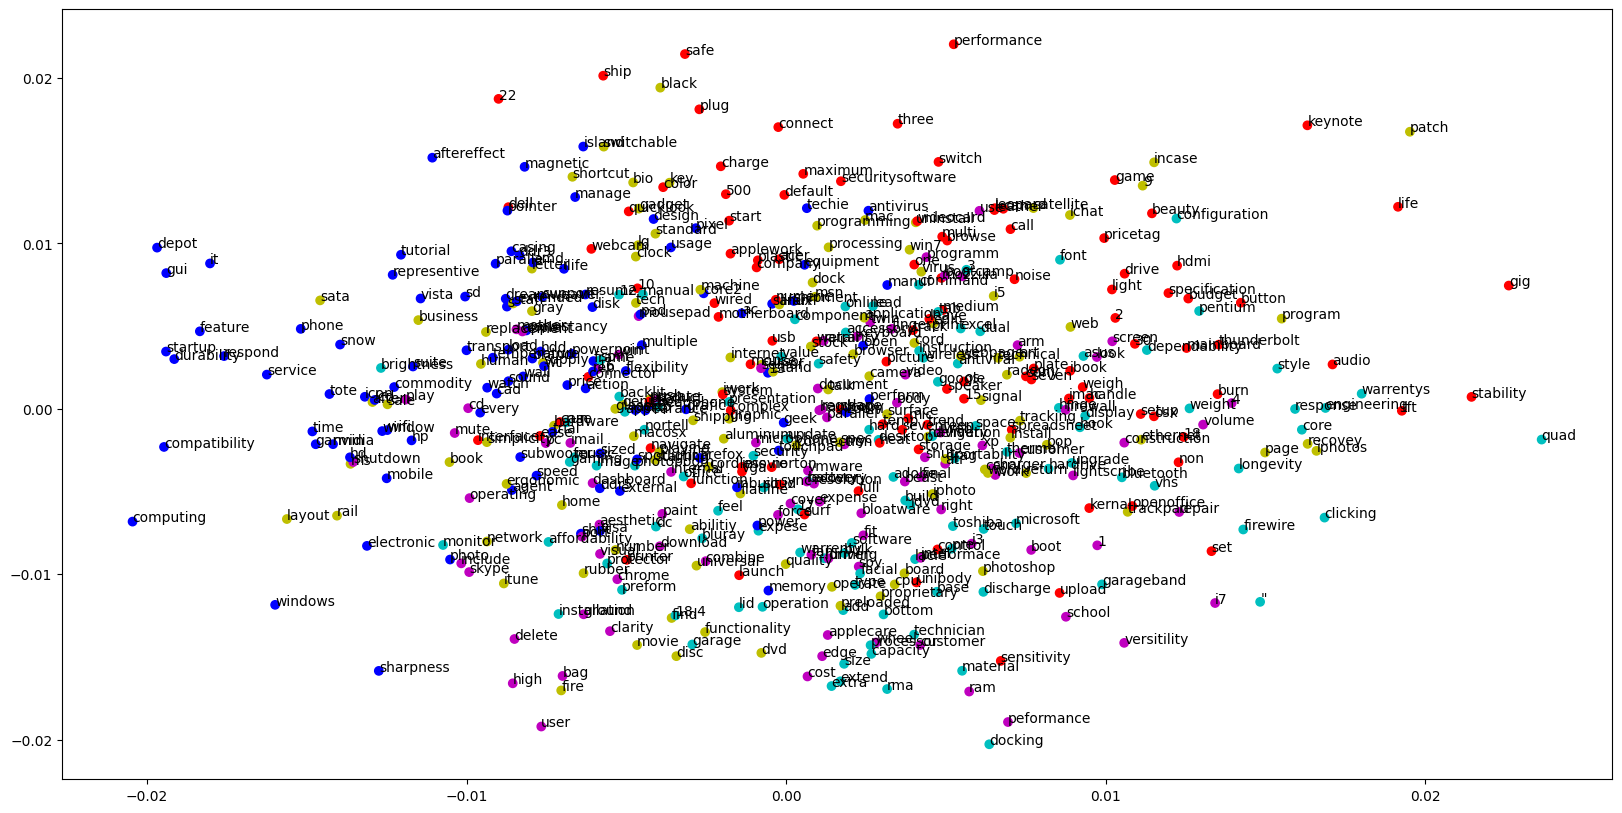

In [85]:
a_aspects=[i for a in all_reviews for i in a["actual_aspects"]]
unique_aspects = clean_aspects(a_aspects)
a_vec, labels = cluster_aspects(unique_aspects)
visualize_clusters(unique_aspects, a_vec, labels)
a_l, l_a = get_words_cluster_pair(unique_aspects, labels)

[KMeans(max_iter=200, n_clusters=2), KMeans(max_iter=200, n_clusters=3), KMeans(max_iter=200, n_clusters=4), KMeans(max_iter=200, n_clusters=5), KMeans(max_iter=200, n_clusters=6)]
sil score: [0.011326757, 0.00956317, 0.009686235, 0.009502627, 0.009510258]
Optimal num of clusters: 2, best silhouette score: 0.01132675725966692
score:  -1.9552471723953313
silhouete score:  0.009179214
Cluster 0: warrenty charm controller freesecuritysoftware bonus email spin macs bio game 
Cluster 1: thing value output satellite address difficulty hdd word boot performance 
Cluster 2: crack connector office surprise pop repair gaming webcam effects- program 
Cluster 3: hdmi luxury grace run write fix use product get hr 
Cluster 4: resolution exaggeration hd signal time bar way case standard inch 


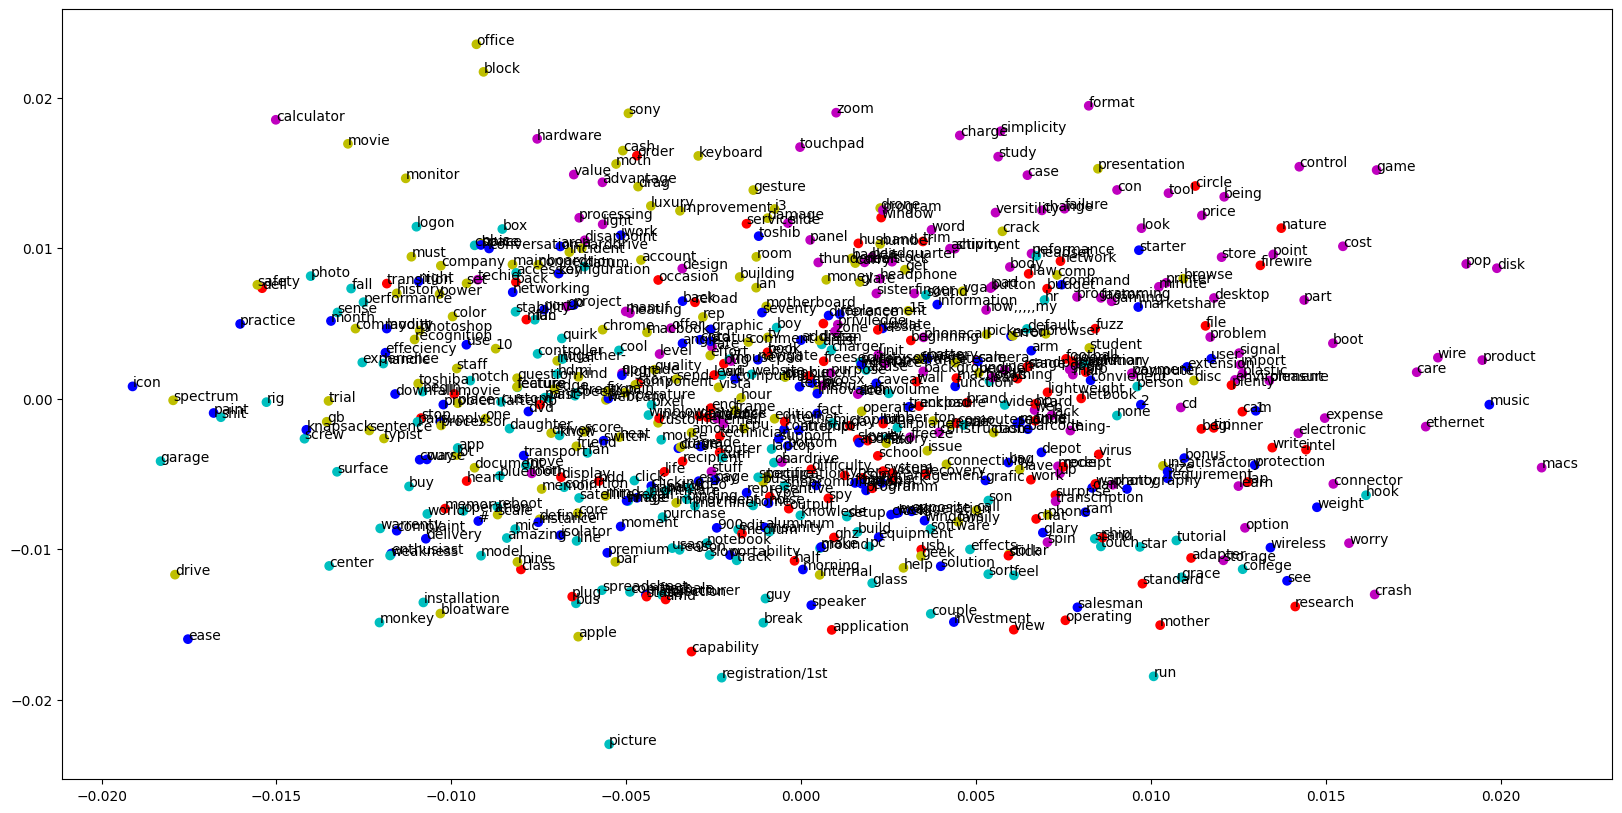

In [86]:
a_aspects=[i for a in all_reviews for i in a["extracted_aspects"]]
unique_aspects = clean_aspects(a_aspects)
a_vec, labels = cluster_aspects(unique_aspects)
visualize_clusters(unique_aspects, a_vec, labels)
a_l, l_a = get_words_cluster_pair(unique_aspects, labels)

In [123]:
# # map aspects with their cluster labels
# map_aspects = dict(zip(aspects, labels))

# # get all words of a cluster in one
# results = defaultdict()
# for k, val in map_aspects.items():
#     if val in results.keys():
#         results[val].append(k)
#     else:
#         results[val] = [k]
# map_aspects

In [104]:
len(aspect_vectors), len(aspect_vectors[0])

(797, 100)

In [29]:
from collections import defaultdict

aspects_map = defaultdict(int)
for asp in aspects:
    aspects_map[asp] +=1

In [22]:
# # get aspect embeddings using word2vec
# from gensim.models import Word2Vec

# model = Word2Vec(aspects, vector_size=100)
# words = model.wv

# aspect vectors using spacy
asp_vectors = []
for a in aspects:
    token = nlp(a)
    asp_vectors.append(token.vector)

In [23]:
# clustering 
# need to convert the aspects into their vectors/numerical forms
NUM_CLUSTERS=4
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(asp_vectors)
labels = kmeans.labels_

In [24]:
# map aspects with their cluster labels
map_aspects = dict(zip(aspects, labels))

# get all words of a cluster in one
results = defaultdict()
for k, val in map_aspects.items():
    if val in results.keys():
        results[val].append(k)
    else:
        results[val] = [k]

In [37]:
# map_aspects

In [38]:
cluster_map = defaultdict()
cluster_to_asp_map = defaultdict()
for i in range(NUM_CLUSTERS):
    cluster_nouns = [k for k, v in map_aspects.items() if v==i]
    freq_map = {k:v for k,v in aspects_map.items() if k in cluster_nouns}
    freq_map = sorted(freq_map.items(), key=lambda x:x[1], reverse=True)
    cluster_map[i] = freq_map[0][0]
    cluster_to_asp_map[i] = cluster_nouns

In [40]:
# print(cluster_to_asp_map)
print(cluster_map)

defaultdict(None, {0: 'service', 1: 'food', 2: 'restaurant', 3: 'place'})


In [19]:
# import sklearn
# from sklearn.metrics import precision_score, recall_score, f1_score

# y_test=data["actual_aspects"]
# y_pred=data["extracted_aspects"]
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1_score = f1_score(y_test, y_pred)

In [113]:
pd.DataFrame(all_reviews).to_csv("output/extracted_aspects_v3.csv")

In [33]:
d = open("datasets/laptops_reviews/laptop_test_unsupervisedABSA.txt", "r+")

In [87]:
with open("datasets/laptops_reviews/laptop_test_unsupervisedABSA.txt") as f:
    lines = f.readlines()
    f.close()

with open("datasets/laptops_reviews/laptop_test_unsupervisedABSA_v1.txt", "w") as f:
    for line in lines:
        f.write(" ".join(line.strip().split()[3:]))
        f.write("\n")
    f.close()

Check how many of them are correct if we use the rules given

In [16]:
# import os

# os.makedirs("output/")

In [22]:
reviews.head()

,id,text,original_aspects
0,3121,But the staff was so horrible to us.,staff
1,2777,"To be completely fair, the only redeeming fact...",food
2,1634,"The food is uniformly exceptional, with a very...",food
3,1634,"The food is uniformly exceptional, with a very...",kitchen
4,1634,"The food is uniformly exceptional, with a very...",menu


In [9]:
from sklearn import cluster
from collections import defaultdict

In [10]:
NUM_CLUSTERS = 4
aspects = []
for review in review_decomp:
    aspect_pairs = review["aspect_pairs"]
    for noun, adj in aspect_pairs:
        # print(noun, adj)
        aspects.append(noun)
        
unique_aspects = list(set(aspects))

In [11]:
len(unique_aspects)

64

In [20]:
aspects_map = defaultdict(int)
for asp in aspects:
    aspects_map[asp] += 1

In [24]:
asp_vectors = []
for aspect in unique_aspects:
    token = nlp(aspect)
    asp_vectors.append(token.vector)
    
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(asp_vectors)
labels = kmeans.labels_
asp_to_cluster_map = dict(zip(unique_aspects, labels))
print(asp_to_cluster_map)

{'benches': 2, 'food': 0, 'questions': 2, 'taste': 0, 'prices': 2, 'place': 2, 'concept': 2, 'setting': 2, 'spot': 0, 'rice': 0, 'above': 2, 'dinner': 0, 'selection': 2, 'dishes': 0, 'experience': 2, 'you': 3, 'decoration': 2, 'Faan': 0, 'I': 3, 'He': 1, 'variety': 2, 'mussels': 0, 'staff': 2, 'which': 2, 'lovers': 0, 'bagels': 0, 'decor': 0, 'choices': 2, 'desert': 0, 'we': 3, 'vibe': 0, 'money': 2, 'size': 2, 'quantity': 2, 'menu': 0, 'perks': 0, 'wine': 0, 'floor': 2, 'pizza': 0, 'broth': 0, 'deficiencies': 2, 'factor': 2, 'people': 2, 'list': 2, 'favorite': 0, 'restaurants': 0, 'price': 2, 'me': 3, 'owner': 0, 'all': 2, 'Bagels': 0, 'They': 2, 'service': 2, 'design': 2, 'meal': 0, 'stomach': 0, 'waiters': 0, 'seats': 2, 'kitchen': 0, 'atmosphere': 2, 'dressing': 2, 'temperatures': 2, 'It': 2, 'texture': 2}


In [28]:
cluster_map = defaultdict()
cluster_to_asp_map = defaultdict()
for i in range(NUM_CLUSTERS):
    cluster_nouns = [k for k, v in asp_to_cluster_map.items() if v==i]
    freq_map = {k:v for k, v in aspects_map.items() if k in cluster_nouns}
    freq_map = sorted(freq_map.items(), key=lambda x: x[1], reverse=True)
    cluster_map[i] = freq_map[0][0]
    cluster_to_asp_map[i] = cluster_nouns

In [30]:
cluster_to_asp_map

defaultdict(None,
            {0: ['food',
              'taste',
              'spot',
              'rice',
              'dinner',
              'dishes',
              'Faan',
              'mussels',
              'lovers',
              'bagels',
              'decor',
              'desert',
              'vibe',
              'menu',
              'perks',
              'wine',
              'pizza',
              'broth',
              'favorite',
              'restaurants',
              'owner',
              'Bagels',
              'meal',
              'stomach',
              'waiters',
              'kitchen'],
             1: ['He'],
             2: ['benches',
              'questions',
              'prices',
              'place',
              'concept',
              'setting',
              'above',
              'selection',
              'experience',
              'decoration',
              'variety',
              'staff',
              'which',
            